In [21]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
import csv
from nltk.corpus import stopwords
import string
import operator
import json
from collections import Counter
from collections import defaultdict
import math
import random

In [2]:
positive_vocab = [':)', ':-)']
negative_vocab = [':(', ':-(']
pos_file = "./positive-words.txt"
neg_file = "./negative-words.txt"
# stop contains all the stopwords in the english language
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 
            'via','RT','the','The',"This",'this','for','if']

In [3]:
# Global Variables
no_tweets = 0
# Counter of all single words
count_all = Counter()
# Counter for all bigrams Co-occurence Matrix
"""
 co-occurrence matrix com such that com[x][y]
 contains the number of times the term x has been
 seen in the same tweet as the term y:
"""
# creates a default dict with all possible keys with values (int)0
com = defaultdict(lambda : defaultdict(int))

In [25]:
#Enter File path here
fname = "./python.json"

In [26]:
with open(pos_file,"r",encoding = "ISO-8859-1") as f_in:
    reader = csv.reader(f_in)
    for word in reader:
        positive_vocab.append(word[0])
with open(neg_file,"r",encoding = "ISO-8859-1") as file:
    reader = csv.reader(file)
    for word in reader:
        negative_vocab.append(word[0])

In [27]:
 def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [28]:
def get_keywords(tweet):
        """
        Utility function to get the keywords for calculating sentiment of tweet
        It Cleans the tweet and tokenizes before returning it
        """
        c_tweet = clean_tweet(tweet)
        terms = c_tweet.split(" ")
        tokens = [term for term in terms 
                  if term not in stop and len(term) > 2]
        return tokens

In [29]:
def get_tweet_sentiment_text_blob(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [30]:
def update_counters(tweet):
        # Create a list with all the terms
        tokens = get_keywords(tweet)
        #updating count_all
        count_all.update(tokens)
        # updating Concurrency matrix
        for i in range(len(tokens)-1):            
            for j in range(i+1, len(tokens)):
                # so that a,b and b,a are both considered same
                w1, w2 = sorted([tokens[i], tokens[j]])                
                if w1 != w2:
                    com[w1][w2] += 1

In [31]:
with open(fname, 'r') as f:
    for line in f:
        try:
            tweet = json.loads(line)
            no_tweets += 1
            update_counters(tweet['text'])
        except:
            #print ("Error on {}".format(no_tweets))
            continue
    # Print the first 5 most frequent words
    print ("The total no of tweets are {}".format(no_tweets))

The total no of tweets are 6412


In [32]:
n_docs = no_tweets

In [33]:
com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    # .items() methord on dictonary returns (key,value) tuples here (t2,no_of_occurences)
    # we are sorting the tuples received by the term t2 using operator.
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
#terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
#print(terms_max[:5])

In [34]:
# n_docs is the total n. of tweets
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in count_all.items():
    #couting probablities of single terms
    p_t[term] = n / n_docs
    # counting probablities of tow terms together
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / n_docs


In [35]:
pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom) 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

In [36]:
# Test Block
semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)

In [37]:
def get_tweet_sentiment(tweet):
        terms_stop = get_keywords(tweet)
        analysis = 0
        for term in terms_stop:
            analysis += semantic_orientation[term]
        # set sentiment
        if analysis > 2:
            return 'positive'
        elif analysis < -2:
            return 'negative'
        else:
            return 'netural'
        return 'neutral'

In [38]:
tweets = []
with open(fname, 'r') as f:
    for line in f:
        try:
            tweet = json.loads(line)
           
            parsed_tweet = {}
            # saving text of tweet
            parsed_tweet['text'] = tweet['text']
            # saving sentiment of tweet
            parsed_tweet['sentiment'] = get_tweet_sentiment(tweet['text'])
            parsed_tweet['sentiment_blob'] = get_tweet_sentiment_text_blob(tweet['text'])
            # appending parsed tweet to tweets list
            if parsed_tweet not in tweets:
                tweets.append(parsed_tweet)
        except Exception as e :
            print ("Exception {}".format(e))
            continue
   

made the printing of the tweets random so as the output changes every time

In [39]:
ptweets = []
ntweets = []
print (len(tweets))
for tweet in tweets:
    if tweet['sentiment'] == 'positive':
        ptweets.append(tweet)
    elif tweet['sentiment'] == 'negative':
            ntweets.append(tweet)
# percentage of positive tweets
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
# picking negative tweets from tweets
#ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
# percentage of negative tweets
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
# percentage of neutral tweets
print("Neutral tweets percentage: {} % \
    ".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets)))
 
# printing first 5 positive tweets
print("\n\nPositive tweets:")
for i in range(10):
    tweet = random.choice(ptweets)
    print(tweet['text'])
# printing first 5 negative tweets
print("\n\nNegative tweets:")
for i in range(10):
    tweet = random.choice(ntweets)
    print(tweet['text'])

320
Positive tweets percentage: 85.3125 %
Negative tweets percentage: 7.5 %
Neutral tweets percentage: 7.1875 %     


Positive tweets:
#allwhiteparty #2018 yanna_j13 ❤👈 @ Austin, Texas https://t.co/ZkLLjwaXNk
RT @redsfer28: all the best to @Loren_Minardi for her #scene which realeses for @Brazzers #debut #girl #ZZrequest  for more new scenes thro…
RT @idevadhikari: Dosti revived...#2018 😉
@aniruddhatony @DEV_PvtLtd https://t.co/HxzYnBmvKy
All presenters are confirmed for #SoulfulSummit #2018! Join us on this #transformation and… https://t.co/xQTZnamLyJ
Thanks @alancommittie for a killer season at TOTB! And for setting the perfect tone to #2018! @Monte_Theatre you're… https://t.co/dJU3KYaqLP
urbselect: sheen magazine - Baecations for Valentine’s Day http://45.33.5.89/sheen-magazine/2018/baecations-for-val… https://t.co/2DxlXdnLgP
RT @Actionjackson: Mood : #2018 ✨ https://t.co/yJvZiWBPAO
#Everything The Spirit Of The LORD Has FOR You Will Be Obtained, Released And Manifested In #2018. I

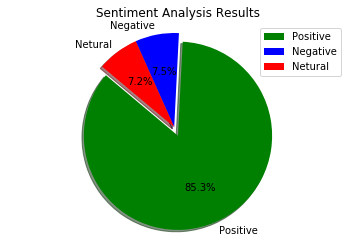

In [40]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Positive', 'Negative', 'Netural'
sizes = [100*len(ptweets)/len(tweets), 100*len(ntweets)/len(tweets),100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets) ]
colors = ['green', 'blue', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend() 
plt.title("Sentiment Analysis Results")
plt.axis('equal')
plt.show()
